In [1]:
import torch as t
import torch.nn as nn
import torchvision

from tqdm.notebook import tqdm_notebook

In [2]:
resnet = torchvision.models.resnet34(weights="DEFAULT")

# Check out names of submodules
[name for name, _ in resnet.named_children()]

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [3]:
# Freeze all layers
for p in resnet.parameters():
    p.requires_grad = False

In [4]:
# Inspect the layer we will replace
resnet.fc

Linear(in_features=512, out_features=1000, bias=True)

In [5]:
# Replace the layer
resnet.fc = nn.Linear(512, 2, bias=True)

In [6]:
# Check that only fc is unfrozen
params_to_train = []
for name, p in resnet.named_parameters():
    if p.requires_grad == True:
        print(name, p.requires_grad)
        params_to_train.append(p)

fc.weight True
fc.bias True


In [7]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.ImageFolder('./data/hymenoptera_data/train', transform)
trainloader = t.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

valset = torchvision.datasets.ImageFolder('./data/hymenoptera_data/val', transform)
valloader = t.utils.data.DataLoader(valset, batch_size=16, shuffle=True)

In [8]:
def calc_accuracy(model, dataloader: t.utils.data.dataloader.DataLoader) -> float:
    '''Get classification accuracy of a model'''
    prior_training_mode = model.training

    model.eval()
    n_correct = 0
    for x, y in valloader:
        preds = model(x).argmax(dim=1)
        n_correct += (preds == y).sum().item()
    accuracy = n_correct / len(valloader.dataset)

    # Restore prior training mode
    if prior_training_mode == True:
        model.train()
    else:
        model.eval()

    return accuracy

In [9]:
num_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = t.optim.SGD(params_to_train, lr=0.001, momentum=0.9)

In [10]:
loss_list = []
accuracy_list = [calc_accuracy(resnet, valloader)]

for epoch in tqdm_notebook(range(1, num_epochs + 1)):

    # Ensure the model is in training mode
    resnet.train()

    for inputs, labels in tqdm_notebook(trainloader, leave=False):
        # Zero grads
        optimizer.zero_grad()

        # Forward pass
        logits = resnet(inputs)

        # Calc loss
        loss = criterion(logits, labels)
        loss_list.append(loss.item())

        # Backprop: calculate grads
        loss.backward()

        # Update weights based on calculated grads
        optimizer.step()

    # Calculate accuracy at end of epoch
    accuracy_list.append(calc_accuracy(resnet, valloader))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [11]:
accuracy_list

[0.6143790849673203,
 0.8169934640522876,
 0.9084967320261438,
 0.8758169934640523,
 0.9150326797385621,
 0.9150326797385621]

<AxesSubplot:>

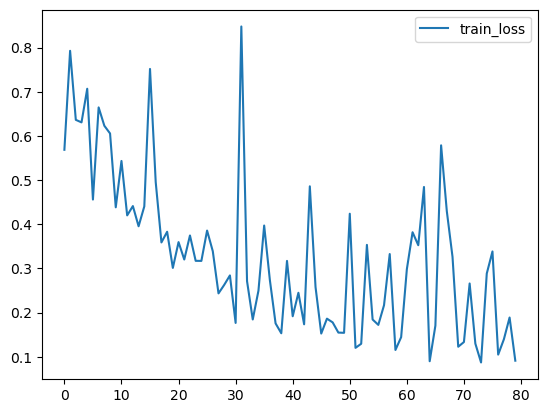

In [13]:
import pandas as pd
pd.DataFrame(data=loss_list, columns=['train_loss']).plot()